## Prophet Modeling

> **Project:** Houston 311 Detector  
> **Author:** Mojoolu (Mojo) Roberts  
> **Environment:** `.venv`  
> **Data Contract:** All notebooks read from raw Houston 311 data that can be downloaded here (link)

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from prophet import Prophet
from sqlalchemy import create_engine
import logging
import os
from dotenv import load_dotenv

load_dotenv()
db_url = os.getenv("DATABASE_URL")
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
pd.set_option("display.float_format", "{:.2f}".format)

In [8]:
# Connect to your Postgres database
engine = create_engine(db_url)

# Load the table into a DataFrame
df = pd.read_sql("SELECT * FROM houston_311", engine)

pio.renderers.default = "notebook_connected"

In [9]:
df.describe

<bound method NDFrame.describe of                    CASE NUMBER                                 NEIGHBORHOOD  \
0        12091834-101002444724                 EAST LITTLE YORK / HOMESTEAD   
1        12091835-101002444725                          NORTHSIDE/NORTHLINE   
2                 101002444726                                     MID WEST   
3                 101002444727  WASHINGTON AVENUE COALITION / MEMORIAL PARK   
4        12091836-101002444730                               GREATER UPTOWN   
...                        ...                                          ...   
3485824             2500463040                        SPRING BRANCH CENTRAL   
3485825             2500463039                         INDEPENDENCE HEIGHTS   
3485826             2500463038                                KINGWOOD AREA   
3485827             2500463037                             ADDICKS PARK TEN   
3485828             2500463036                         INDEPENDENCE HEIGHTS   

                 

In [10]:
df.dtypes

CASE NUMBER                     object
NEIGHBORHOOD                    object
DEPARTMENT                      object
DIVISION                        object
CASE TYPE                       object
CREATED DATE            datetime64[ns]
CLOSED DATE             datetime64[ns]
LATITUDE                       float64
LONGITUDE                      float64
CATEGORY                        object
RESOLUTION_TIME_DAYS           float64
dtype: object

In [11]:
df[df["CREATED DATE"] > pd.Timestamp.today()]

,CASE NUMBER,NEIGHBORHOOD,DEPARTMENT,DIVISION,CASE TYPE,CREATED DATE,CLOSED DATE,LATITUDE,LONGITUDE,CATEGORY,RESOLUTION_TIME_DAYS


In [12]:
cols = ["NEIGHBORHOOD", "DEPARTMENT", "DIVISION", "CATEGORY", "CASE TYPE"]

for c in cols:
    df[c] = (
        df[c]
        .astype(str)
        .str.strip()
        .str.title()
        .str.replace("\s+", " ", regex=True)
    )

## Forecast Citywide 311 Complaint Volume (Prophet)

**Purpose**  
Model and forecast monthly 311 complaint volume at the citywide level.

**Data Preparation**
- Aggregate complaints to month-end frequency using `CREATED DATE`
- Rename columns to Prophet’s required schema:
  - `ds`: timestamp
  - `y`: complaint count
- Exclude months with insufficient data to avoid unstable signals
- Remove the most recent incomplete month to prevent partial-month bias

**Modeling Approach**
- Prophet time-series model
- 95% uncertainty interval
- Daily seasonality enabled to capture intra-month effects

**Forecast**
- Generate predictions for the next 12 months
- Output includes trend, seasonality, and uncertainty bounds

**Why This Matters**
- Establishes a citywide baseline forecast
- Serves as a reference for neighborhood- and category-level models
- Helps validate whether trends observed in EDA persist forward

**Notes**
- This model operates on volume only (not resolution time)
- Results are exploratory; production forecasts are generated separately


In [13]:
# Aggregate by month
overall_ts = (
    df.groupby(pd.Grouper(key='CREATED DATE', freq='ME'))
      .size()
      .reset_index(name='y')
      .rename(columns={'CREATED DATE': 'ds'})
)

# Remove months with too few rows
cleaned_ts = overall_ts[overall_ts["y"] > 1000] 

# Determine the last fully complete month
last_month = cleaned_ts['ds'].max()
cleaned_ts = cleaned_ts[cleaned_ts['ds'] < last_month]

# Fit Prophet
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(cleaned_ts)

# Forecast next 12 months
future = m.make_future_dataframe(periods=12, freq='ME')
forecast = m.predict(future)

21:56:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


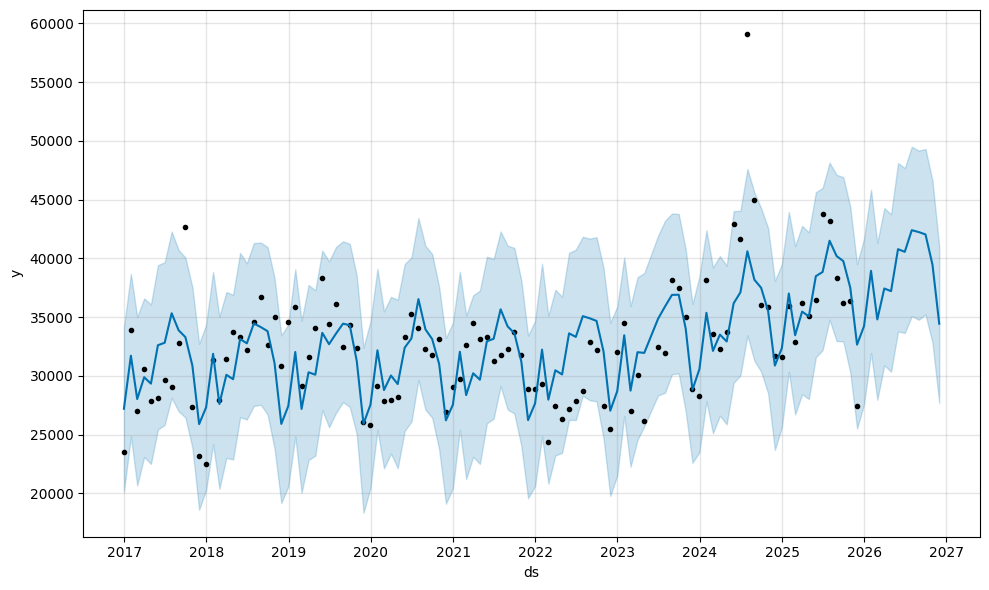

In [14]:
plot1 = m.plot(forecast)

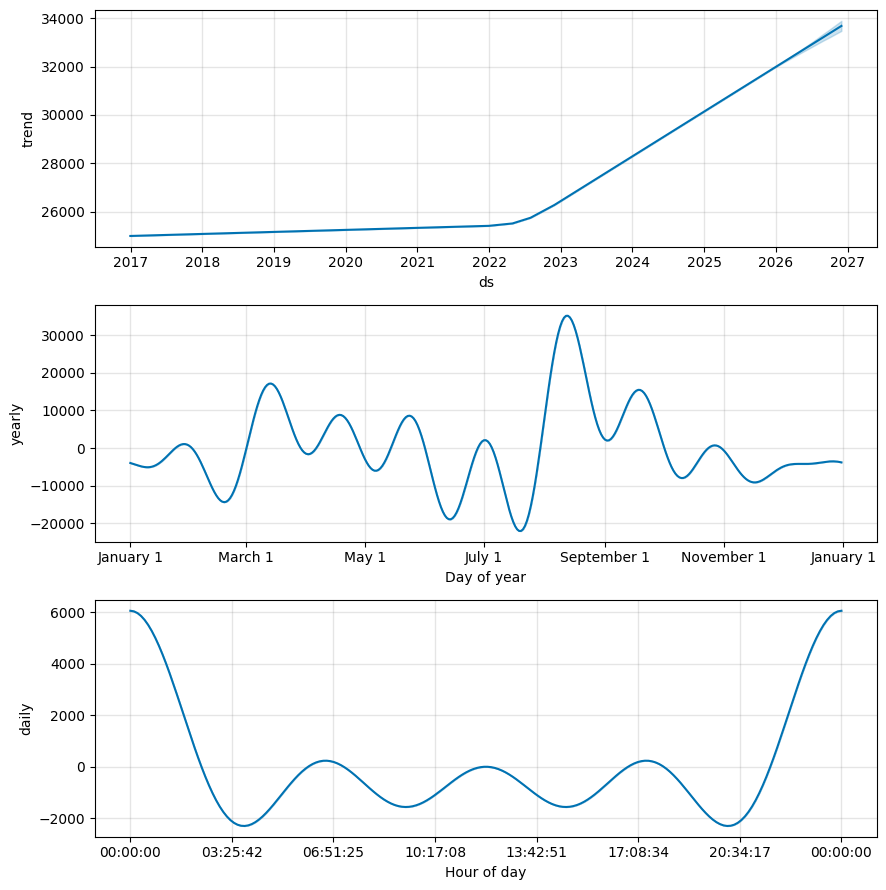

In [15]:
plot2 = m.plot_components(forecast)

## Evaluate Forecast Accuracy (In-Sample)

**Purpose**  
Assess how well the Prophet model fits historical 311 complaint volume.

**Method**
- Merge forecasted values with observed historical data
- Restrict evaluation to the training (historical) period
- Compare actual counts (`y`) against model predictions (`yhat`)

**Metrics Reported**
- **MAE (Mean Absolute Error):** average absolute deviation in complaint counts
- **RMSE (Root Mean Squared Error):** penalizes larger errors more heavily
- **MAPE (Mean Absolute Percentage Error):** relative error expressed as a percentage

**Why This Matters**
- Quantifies model fit before trusting future projections
- Provides a baseline for comparing alternative models or configurations
- Helps determine whether the model is sufficiently reliable for interpretation

**Notes**
- Metrics are in-sample and may be optimistic
- Out-of-sample validation is recommended for production use


In [16]:
# Merge forecasted values with actuals
results = cleaned_ts.merge(forecast, on='ds', how='left')

# Keep only training portion (historical)
historical = results[results['ds'] <= cleaned_ts['ds'].max()]

In [17]:
# Calculate error metrics
y_true = historical['y']
y_pred = historical['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  2615.60
RMSE: 3564.77
MAPE: 8.02%


In [18]:
# Keep only periods that exist in your original data
actual = cleaned_ts.set_index("ds")
predicted = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]

# Join actuals with predictions
compare = actual.join(predicted, how="left")

# Compute residuals (errors)
compare["error"] = compare["y"] - compare["yhat"]
compare.head()

,y,yhat,yhat_lower,yhat_upper,error
ds,,,,,
2016-12-31,23529,27195.86,20134.42,34133.12,-3666.86
2017-01-31,33903,31706.50,24840.90,38673.90,2196.50
2017-02-28,26991,28020.70,20659.17,35003.65,-1029.70
2017-03-31,30619,29877.15,23088.03,36589.14,741.85
2017-04-30,27820,29330.90,22498.69,36068.26,-1510.90


In [19]:
# Identify top 3 neighborhoods by volume
top_3_neigh = (
    df["NEIGHBORHOOD"]
    .value_counts()
    .head(3)
    .index
    .tolist()
)

results = []

for neigh in top_3_neigh:
    # Filter neighborhood
    sub = df[df["NEIGHBORHOOD"] == neigh].copy()

    # Monthly aggregation
    ts = (
        sub
        .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="y")
        .rename(columns={"CREATED DATE": "ds"})
        .sort_values("ds")
    )

    # Drop low-volume months
    ts = ts[ts["y"] > 50]

    # Drop last incomplete month
    last_month = ts["ds"].max()
    ts = ts[ts["ds"] < last_month]

    # Skip if not enough history
    if len(ts) < 24:
        print(f"⚠️ Skipping {neigh}: insufficient data")
        continue

    # Fit Prophet
    m = Prophet(interval_width=0.95, yearly_seasonality=True)
    m.fit(ts)

    # Forecast
    future = m.make_future_dataframe(periods=12, freq="ME")
    forecast = m.predict(future)

    # Merge predictions with actuals
    merged = ts.merge(
        forecast[["ds", "yhat"]],
        on="ds",
        how="left"
    )

    # Error metrics (in-sample)
    y_true = merged["y"]
    y_pred = merged["yhat"]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    results.append({
        "Neighborhood": neigh,
        "Months": len(ts),
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2),
    })

# Final results table
forecast_eval = pd.DataFrame(results).sort_values("MAPE (%)")
forecast_eval

22:05:40 - cmdstanpy - INFO - Chain [1] start processing
22:05:40 - cmdstanpy - INFO - Chain [1] done processing
22:05:41 - cmdstanpy - INFO - Chain [1] start processing
22:05:41 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing


,Neighborhood,Months,MAE,RMSE,MAPE (%)
1,Alief,107,121.94,149.64,11.36
2,Central Southwest,107,130.44,168.82,12.26
0,Greater Heights,107,164.85,229.16,13.75


## Forecast with Confidence Intervals and Rolling Trend Extension

**Purpose**  
Visualize neighborhood-level forecasts with uncertainty bounds and a smoothed trend that bridges historical data into the forecast horizon.

**Components**
- Actual monthly complaint counts
- 3-month rolling trend computed on historical data
- Prophet forecast extending beyond the last observed month
- 95% confidence interval around forecasted values

**Why This Matters**
- Rolling trend provides continuity from history into projections
- Confidence intervals communicate forecast uncertainty explicitly
- Prevents over-interpreting point forecasts

**Notes**
- Rolling trend is diagnostic and not used for modeling
- Wider intervals indicate lower forecast reliability


In [29]:
for neigh in top_3_neigh:
    sub = df[df["NEIGHBORHOOD"] == neigh].copy()

    ts = (
        sub
        .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="y")
        .rename(columns={"CREATED DATE": "ds"})
        .sort_values("ds")
    )

    ts = ts[ts["y"] > 50]
    ts = ts[ts["ds"] < ts["ds"].max()]

    if len(ts) < 24:
        continue

    # Rolling trend on actuals
    ts["Rolling_3M"] = ts["y"].rolling(3, center=True).mean()

    # Prophet model
    m = Prophet(interval_width=0.95, yearly_seasonality=True)
    m.fit(ts[["ds", "y"]])

    future = m.make_future_dataframe(periods=12, freq="ME")
    forecast = m.predict(future)

    # Split forecast portion
    fc = forecast[forecast["ds"] > ts["ds"].max()]
    
    cutoff = ts["ds"].max()

    combined = pd.concat([
        ts[["ds", "y"]].rename(columns={"y": "value"}),
        fc[["ds", "yhat"]].rename(columns={"yhat": "value"}),
    ]).sort_values("ds")

    combined["Rolling_3M_Full"] = (
        combined["value"]
        .rolling(window=3, min_periods=1, center=False)
        .mean()
    )

    # keep last 2 actual points so the first forecast rolling value is valid
    combined_plot = combined[combined["ds"] >= (cutoff - pd.offsets.MonthEnd(2))]
    combined_plot = combined_plot[combined_plot["ds"] > cutoff]


    fig = go.Figure()

    # Actuals
    fig.add_trace(go.Scatter(
        x=ts["ds"],
        y=ts["y"],
        mode="lines+markers",
        name="Actuals",
        line=dict(width=2)
    ))

    # Forecast line
    fig.add_trace(go.Scatter(
        x=fc["ds"],
        y=fc["yhat"],
        mode="lines",
        name="Forecast",
        line=dict(width=3, dash="dash")
    ))

    # Confidence interval band
    fig.add_trace(go.Scatter(
        x=pd.concat([fc["ds"], fc["ds"][::-1]]),
        y=pd.concat([fc["yhat_upper"], fc["yhat_lower"][::-1]]),
        fill="toself",
        fillcolor="rgba(255,255,255,0.12)",
        line=dict(color="rgba(255,255,255,0)"),
        hoverinfo="skip",
        name="95% CI"
    ))
    
    fig.add_trace(go.Scatter(
        x=combined_plot["ds"],
        y=combined_plot["Rolling_3M_Full"],
        mode="lines",
        name="3M Rolling Trend (Actuals → Forecast)",
        line=dict(width=4)
    ))



    fig.update_layout(
        title=f"Monthly 311 Complaint Forecast — {neigh}",
        template="plotly_dark",
        height=700,
        hovermode="x unified",
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        font_color="#FFF",
        hoverlabel=dict(
            bgcolor="rgba(20,20,20,0.95)",
            font_color="#EAEAEA",
            bordercolor="#555",
            font_size=13,
            font_family="Inter, Arial, sans-serif",
        )
    )

    fig.show()


In [ ]:
category_col = "NEIGHBORHOOD"
date_col = "CREATED DATE"  

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

In [ ]:
category_col = "DEPARTMENT" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)
print(results_df)

In [ ]:
category_col = "DIVISION" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

In [ ]:
category_col = "CATEGORY" 
date_col = "CREATED DATE"     

results = []

for cat, group in df.groupby(category_col, observed=True):
    ts = (
        group.groupby(pd.Grouper(key=date_col, freq="ME"))
             .size()
             .reset_index(name="y")
             .rename(columns={date_col: "ds"})
             .sort_values("ds")
    )
    
    # Exclude last incomplete month
    if not ts.empty:
        last_month = ts['ds'].max()
        ts = ts[ts['ds'] < last_month]
    
    # Skip if too few data points
    if len(ts) < 24:
        continue

    # Train-test split
    train = ts[:-6]
    test = ts[-6:]
    
    # Fit Prophet
    m = Prophet()
    m.fit(train)
    
    # Make future and predict for test dates
    future = m.make_future_dataframe(periods=6, freq="ME")
    forecast = m.predict(future)
    forecast_test = forecast.tail(6).copy()
    forecast_test["y_true"] = test["y"].values
    
    # Compute metrics
    mae = mean_absolute_error(forecast_test["y_true"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast_test["y_true"], forecast_test["yhat"]))
    mape = np.mean(np.abs((forecast_test["y_true"] - forecast_test["yhat"]) / forecast_test["y_true"])) * 100
    
    results.append({
        "Category": cat,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values("MAPE (%)")
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

In [ ]:
cap = df["RESOLUTION_TIME_DAYS"].quantile(0.95)
df["RESOLUTION_TIME_DAYS"] = df["RESOLUTION_TIME_DAYS"].clip(upper=cap)

In [ ]:
# Find the two most recent months in your data
latest_date = df["CREATED DATE"].max()
latest_month_start = latest_date.replace(day=1)
second_latest_month_start = (latest_month_start - pd.DateOffset(months=1))

# Keep only rows before these two months
df_model = df[df["CREATED DATE"] < second_latest_month_start].copy()


In [ ]:
# Median per case type (can contain NaN)
medians_by_type = df_model.groupby('CASE TYPE')['RESOLUTION_TIME_DAYS'].median()

# Map case-type median to rows
df_model['MEDIAN_BY_TYPE'] = df_model['CASE TYPE'].map(medians_by_type)

# Fill missing durations ONLY where case-type median exists
df_model['RESOLUTION_TIME_DAYS'] = df_model.apply(
    lambda row: row['MEDIAN_BY_TYPE'] if pd.isna(row['RESOLUTION_TIME_DAYS']) and not pd.isna(row['MEDIAN_BY_TYPE'])
    else row['RESOLUTION_TIME_DAYS'],
    axis=1
)

# Drop rows where RESOLUTION_TIME_DAYS is still NaN AND the case type median was also NaN
df_model = df_model.dropna(subset=['RESOLUTION_TIME_DAYS'])

In [ ]:
# Case volume per month
monthly_volume = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
    .size()
    .reset_index(name="case_volume")
)

# Dominant case-type proportion
case_type_monthly = (
    df_model
    .groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
    .size()
    .reset_index(name="count")
)

month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)

dominant_prop = (
    case_type_monthly
    .sort_values(["CREATED DATE", "prop"], ascending=[True, False])
    .groupby("CREATED DATE")
    .first()
    .reset_index()[["CREATED DATE", "prop"]]
    .rename(columns={"prop": "dominant_case_prop"})
)


# BUILD FORECASTING TS (y + regressors)
ts = (
    df_model
    .groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
    .mean()
    .reset_index()
    .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
)

# Merge regressors
ts = (
    ts
    .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
)


# INTERPOLATE MISSING MONTHS (critical for regressors)
full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")

ts = ts.set_index("ds").reindex(full_range)

for col in ["y", "case_volume", "dominant_case_prop"]:
    ts[col] = ts[col].interpolate().bfill().ffill()

ts = ts.rename_axis("ds").reset_index()


# TRAIN/TEST SPLIT
ts = ts[ts["ds"] < pd.Timestamp("2025-11-01")]
train = ts[ts['ds'] >= '2022-01-01']
# train = ts.iloc[:-6]
test = ts.iloc[-6:]


# PROPHET WITH REGRESSORS

model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.8,
)

model.add_regressor("case_volume")
model.add_regressor("dominant_case_prop")

model.fit(train)

# Build future df with regressors\
future = model.make_future_dataframe(periods=12, freq="ME")
future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]],
                      on="ds", how="left")

# Forward-fill for future months
future["case_volume"] = future["case_volume"].ffill()
future["dominant_case_prop"] = future["dominant_case_prop"].ffill()

forecast = model.predict(future)

pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")

mape = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100
print(f"MAPE: {mape:.2f}%")

# Plot
fig = px.line(train, x='ds', y='y', title='Resolution Time Forecast', labels={'y':'Resolution Days'})
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines+markers', name='Actual')

# Plot predictions on test set (if desired)
fig.add_scatter(x=pred['ds'], y=pred['yhat'], mode='lines', name='Forecast (Test)')

# Plot future predictions
future_forecast = forecast[forecast['ds'] > train['ds'].max()]
fig.add_scatter(x=future_forecast['ds'], y=future_forecast['yhat'], mode='lines+markers', 
                name='Forecast (Future)', line=dict(dash='dash', color='red'))

fig.show()

In [ ]:
groups = df_model["NEIGHBORHOOD"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["NEIGHBORHOOD"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df


In [ ]:
groups = df_model["DEPARTMENT"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["DEPARTMENT"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
print(mape_df)

In [ ]:
groups = df_model["DIVISION"].unique()
mape_results = {}
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

for g in groups:
    subset = df_model[df_model["DIVISION"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df

In [ ]:
groups = df_model["CATEGORY"].unique()
mape_results = {}

for g in groups:
    subset = df_model[df_model["CATEGORY"] == g].copy()
    
    # Drop rows without resolution or created dates
    subset = subset.dropna(subset=["RESOLUTION_TIME_DAYS", "CREATED DATE"])
    if len(subset) < 12:  # skip tiny groups
        continue
    
    # Compute regressors per group    
    # Case volume
    monthly_volume = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))
        .size()
        .reset_index(name="case_volume")
    )
    
    # Dominant case-type proportion
    case_type_monthly = (
        subset.groupby([pd.Grouper(key="CREATED DATE", freq="ME"), "CASE TYPE"])
        .size()
        .reset_index(name="count")
    )
    month_totals = case_type_monthly.groupby("CREATED DATE")["count"].sum()
    case_type_monthly["prop"] = case_type_monthly["count"] / case_type_monthly["CREATED DATE"].map(month_totals)
    dominant_prop = (
        case_type_monthly.sort_values(["CREATED DATE", "prop"], ascending=[True, False])
        .groupby("CREATED DATE")
        .first()
        .reset_index()[["CREATED DATE", "prop"]]
        .rename(columns={"prop": "dominant_case_prop"})
    )
    
    # Build time series with regressors
    ts = (
        subset.groupby(pd.Grouper(key="CREATED DATE", freq="ME"))["RESOLUTION_TIME_DAYS"]
        .mean()
        .reset_index()
        .rename(columns={"CREATED DATE": "ds", "RESOLUTION_TIME_DAYS": "y"})
    )
    
    ts = (
        ts
        .merge(monthly_volume.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
        .merge(dominant_prop.rename(columns={"CREATED DATE": "ds"}), on="ds", how="left")
    )
    
    # Interpolate missing months
    full_range = pd.date_range(ts["ds"].min(), ts["ds"].max(), freq="ME")
    ts = ts.set_index("ds").reindex(full_range)
    for col in ["y", "case_volume", "dominant_case_prop"]:
        ts[col] = ts[col].interpolate().bfill().ffill()
    ts = ts.rename_axis("ds").reset_index()
    
    # Train/test split
    train = ts.iloc[:-6]
    if train['y'].dropna().shape[0] < 2:
        continue
    test = ts.iloc[-6:]
    
    # Prophet with regressors
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.8)
    model.add_regressor("case_volume")
    model.add_regressor("dominant_case_prop")
    
    model.fit(train)
    
    # Build future dataframe
    future = model.make_future_dataframe(periods=12, freq="ME")
    future = future.merge(ts[["ds", "case_volume", "dominant_case_prop"]], on="ds", how="left")
    future["case_volume"] = future["case_volume"].ffill()
    future["dominant_case_prop"] = future["dominant_case_prop"].ffill()
    
    forecast = model.predict(future)
    
    # Evaluate
    pred = forecast[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")
    mape_results[g] = mean_absolute_percentage_error(pred["y"], pred["yhat"]) * 100

# Final MAPE table
mape_df = pd.DataFrame.from_dict(mape_results, orient="index", columns=["MAPE"])
mape_df["MAPE"] = mape_df["MAPE"].apply(lambda x: round(x, 2))
mape_df.sort_values("MAPE", inplace=True)
mape_df